<a href="https://colab.research.google.com/github/jejjohnson/gp_model_zoo/blob/master/code/numpyro/numpyro_sparsegp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Gaussian Process w/ Numpyro

My starting notebook where I install all of the necessary libraries and load some easy 1D/2D Regression data to play around with.

In [ ]:
#@title Install Packages
%%capture
!pip install jax jaxlib chex optax loguru
!pip install "git+https://github.com/pyro-ppl/numpyro.git#egg=numpyro"
!pip uninstall tensorflow -y -q
!pip install -Uq tfp-nightly[jax] > /dev/null

In [ ]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# JAX SETTINGS
import jax
import jax.numpy as jnp
import jax.random as random


# JAX UTILITY LIBRARIES
import chex

# NUMPYRO SETTINGS
import numpyro
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoDiagonalNormal
from numpyro.infer import SVI, Trace_ELBO

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import loguru

%load_ext autoreload
%autoreload 2

## Sparse GP Model

In [ ]:
seed = 123
key = jax.random.PRNGKey(seed=seed)

N = 1_000
Ninducing = 50
Nfeatures = 1
Ntest = 1_000
noise = 0.2


# x = jax.random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
# signal = f(x)
# y = signal + jax.random.normal(key, shape=signal.shape) * noise

# xtest = jnp.linspace(-3.5, 3.5, Ntest).reshape(-1, 1)
# ytest = f(xtest)


# x = jax.random.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
# signal = f(x)
# y = signal + jax.random.normal(key, shape=signal.shape) * noise

# x = jax.random.uniform(key=key, minval=0.0, maxval=5.0, shape=(N,)).sort().reshape(-1, 1)
# f = lambda x: 0.5 * jnp.sin(3.0 * x)
# signal = f(x)
# y = signal + noise * jax.random.normal(key, shape=signal.shape)

# rng.rand(N, 1) * 2 - 1 
x = jnp.linspace(-1.0, 1., 1_000).reshape(-1, 1) #* 2.0 - 1.0
f = lambda x: jnp.sin(x * 3 * 3.14) + 0.3 * jnp.cos(x * 9 * 3.14) + 0.5 * jnp.sin(x * 7 * 3.14)

signal = f(x)
y = signal + noise * jax.random.normal(key, shape=signal.shape)


xtest = jnp.linspace(-1.1, 1.1, 1_000).reshape(-1, 1)
ytest = f(xtest)

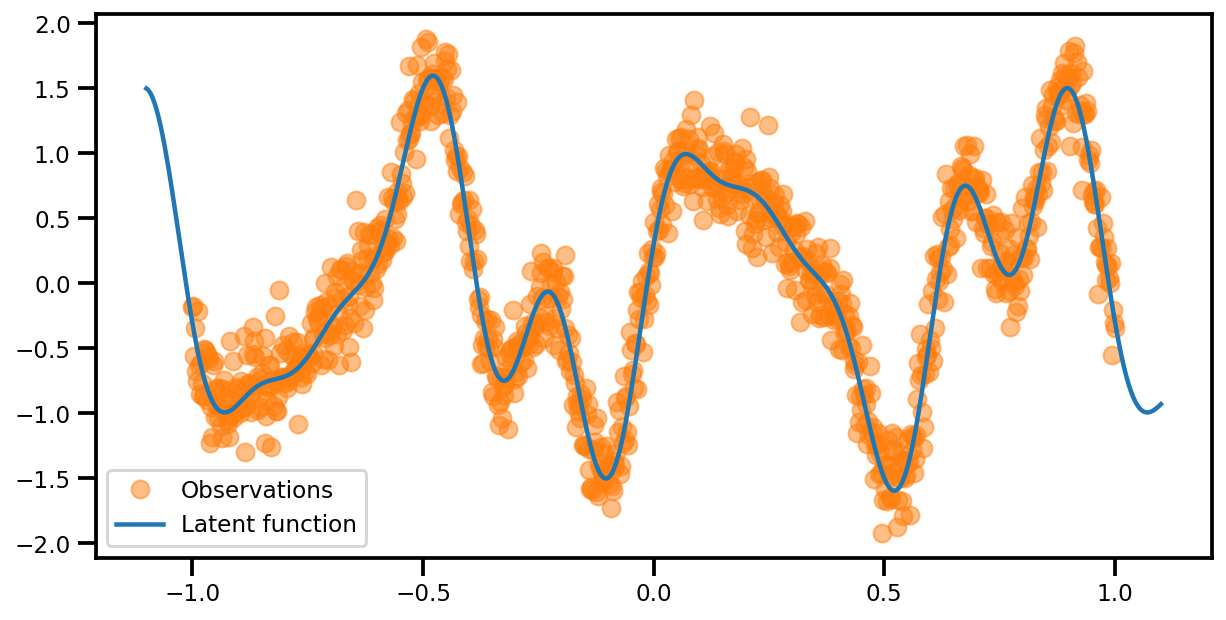

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y, "o", label="Observations", color="tab:orange", alpha=0.5)
ax.plot(xtest, ytest, label="Latent function", color="tab:blue")
ax.legend(loc="best")
plt.show()

### Model

In [ ]:
# squared euclidean distance
def sqeuclidean_distance(x: np.array, y: np.array) -> float:
    return jnp.sum((x - y) ** 2)

# distance matrix
def cross_covariance(func: Callable, x: np.ndarray, y: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda y1: func(x1, y1))(y))(x)


# distance matrix
def gram(func: Callable, x: np.ndarray) -> np.ndarray:
    """distance matrix"""
    return jax.vmap(lambda x1: jax.vmap(lambda x2: func(x1, x2))(x))(x)

# kernel function
def rbf_kernel(X, Y, variance, length_scale):
    # distance formula
    deltaXsq = cross_covariance(
        sqeuclidean_distance, 
        X / length_scale, 
        Y / length_scale
    )

    # rbf function
    K = variance * jnp.exp(-0.5 * deltaXsq)
    return K

# def cholesky_factorization(K: np.ndarray, Y: np.ndarray) -> Tuple[np.ndarray, bool]:
#     """Cholesky Factorization"""
#     # cho factor the cholesky
#     L = jax.scipy.linalg.cho_factor(K, lower=True)

#     # weights
#     weights = jax.scipy.linalg.cho_solve(L, Y)

#     return L, weights

def cholesky_factorization(K: np.ndarray, Y: np.ndarray) -> Tuple[chex.Array, chex.Array]:
    """Cholesky Factorization"""
    # cho factor the cholesky
    L = jax.scipy.linalg.cho_factor(K, lower=True)

    # weights
    W = jax.scipy.linalg.cho_solve(L, Y, lower=True)

    return W

def stablise(K: np.ndarray, jitter: float=1e-6)-> np.ndarray:

    return jax.ops.index_add(K, jnp.diag_indices(K.shape[0]), jitter)

#### Inducing Points

In [ ]:
from scipy.cluster.vq import kmeans2

def init_inducing_kmeans(x: chex.Array, n_inducing: int)-> chex.Array:
    # conver to numpy array
    x = np.array(x)

    # calculate k-means
    x_u_init = kmeans2(x, n_inducing, minit="points")[0]

    # convert to jax array
    x_u_init = jnp.array(x_u_init)

    return x_u_init

def init_inducing_subsample(key, x: chex.Array, n_inducing: int) -> chex.Array:

    # random permutation and subsample
    x_u_init = jax.random.permutation(key, x)[:n_inducing]

    return x_u_init

Ninducing = 20

# # initialize with subsample
# x_u_init = init_inducing_subsample(key, x, Ninducing)

# initialize
x_u_init = init_inducing_kmeans(x, Ninducing)
print(x_u_init.shape)

(20, 1)


$$\mathbf{Q} = k(\mathbf{X},\mathbf{X_u})$$

$$
u \sim \mathcal{GP}(\mathbf{0}, k(\mathbf{x_u}, \mathbf{x_u}))\\
f \sim q(f|\mathbf{X},\mathbf{X_u})=\mathbf{E}_{p(\mathbf{u})}q(\mathbf{f}|\mathbf{X,X_u,u})\\
y \sim \mathbf{f} + \epsilon
$$

We assume the Nystroem decomposition:

$$
\mathbf{Q}_{ff}= \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf}
$$


We minimize the following cost function:

$$
\mathcal{L}(\boldsymbol{\Theta}) = 
\frac{N}{2}\log 2\pi +
\frac{1}{2}\log \left| \mathbf{Q}_{ff}+\mathbf{G} \right| +
\frac{1}{2}\mathbf{y}^\top
\left( \mathbf{Q}_{ff}+\mathbf{G} \right)^{-1}\mathbf{y} +
\frac{1}{2\sigma_n^2}\text{trace}(\mathbf{T})
$$

where:
* The first term is a constant
* The second term is the complexity penalty that characterizes the volume of the distribution.
* The third term penalizes data outside of the covariance ellipse
* The last term ensures that the loss is under the lower bound of the MLE.

---



#### Comparing Models


| Model |   $\mathbf{W}$  |                             $\mathbf{G}$                            |           $\mathbf{T}$          |
|:-----:|:---------------:|:-------------------------------------------------------------------:|:-------------------------------:|
|  FITC | $\mathbf{Q}_{ff}$ | $\text{diag}(\mathbf{K}_{ff} - \mathbf{Q}_{ff}) + \sigma_n^2\mathbf{I}$ |                0                |
|  DTC  | $\mathbf{Q}_{ff}$ |                        $\sigma_n^2\mathbf{I}$                       | $\mathbf{K}_{ff} - \mathbf{Q}_{ff}$ |
|  VFE  | $\mathbf{Q}_{ff}$ |                        $\sigma_n^2\mathbf{I}$                       |                0                |



#### Implementation Details


We can use the `LowRankMultivariateNormal` distribution (e.g. [PyTorch](https://pytorch.org/docs/stable/distributions.html#lowrankmultivariatenormal), [Numpyro](https://num.pyro.ai/en/stable/distributions.html#lowrankmultivariatenormal), and [TensorFlow Probility](https://www.tensorflow.org/probability/api_docs/python/tfp/substrates/jax/distributions/MultivariateNormalDiagPlusLowRank)). It assumes a covariance matrix of the following form:

$$
\mathbf{WW}^\top + \mathbf{D}
$$

We have our nystroem decomposition, $\mathbf{Q}_{ff}$ and our diagonal term $\mathbf{G}$ which make up our covariance matrix. But now, we would like to manipulate it in terms of $\mathbf{W}$ and $\mathbf{G}$ such that:

$$
\mathbf{Q}_{ff} + \mathbf{G} = \mathbf{WW}^\top + \mathbf{D}
$$

We can find $\mathbf{Q}_{ff}$ with a little matrix algebra:

$$
\begin{aligned}
\mathbf{Q}_{ff} &= \mathbf{K}_{fu}\mathbf{K}_{uu}^{-1}\mathbf{K}_{uf} \\
&= \mathbf{K}_{fu}\mathbf{L}_{uu}^{-1}(\mathbf{L}_{uu}^{-1})^\top\mathbf{K}_{uf} \\
&= \mathbf{WW}^\top
\end{aligned} 
$$

Notice how we incorporated the cholesky decomposition to aid stability. $\mathbf{D}$ is much more straight forward as $\mathbf{D} = \mathbf{G}$ from our table above.

In [ ]:

jitter = 1e-4

def SparseGP(X, y):

    n_samples = X.shape[0]
    X = numpyro.deterministic("X", X)
    # Set informative priors on kernel hyperparameters.
    η = numpyro.sample("kernel_var", dist.LogNormal(scale=5.))
    ℓ = numpyro.sample("kernel_length", dist.Gamma(2., 1.))
    σ = numpyro.sample("sigma", dist.HalfCauchy(scale=5.))

    x_u = numpyro.param("x_u", init_value=x_u_init)

    # η = numpyro.param("kernel_var", init_value=1.0, constraints=dist.constraints.positive)
    # ℓ = numpyro.param("kernel_length", init_value=0.1,  constraints=dist.constraints.positive)
    # σ = numpyro.param("sigma", init_value=0.1, onstraints=dist.constraints.positive)

    # ================================
    # Mean Function
    # ================================
    f_loc = np.zeros(n_samples)

    # ================================
    # Qff Term
    # ================================
    # W   = (inv(Luu) @ Kuf).T
    # Qff = Kfu @ inv(Kuu) @ Kuf
    # Qff = W @ W.T
    # ================================
    Kuu = rbf_kernel(x_u, x_u, η, ℓ)
    Kuf = rbf_kernel(x_u, X, η, ℓ)
    # Kuu += jnp.eye(Ninducing) * jitter
    # add jitter
    Kuu = stablise(Kuu, jitter)

    # cholesky factorization
    Luu = jax.scipy.linalg.cholesky(Kuu, lower=True)
    Luu = numpyro.deterministic("Luu", Luu)

    # W matrix
    W = jax.scipy.linalg.solve_triangular(Luu, Kuf, lower=True)
    W = numpyro.deterministic("W", W).T

    # ================================
    # Likelihood Noise Term
    # ================================
    # D = noise
    # ================================
    D = numpyro.deterministic("G", jnp.ones(n_samples) * σ)
    
    # ================================
    # trace term
    # ================================
    # t = tr(Kff - Qff) / noise
    # t = - t / 2.0
    # ================================
    Kffdiag = jnp.diag(rbf_kernel(X, X, η, ℓ))
    Qffdiag = jnp.power(W, 2).sum(axis=1)
    trace_term = (Kffdiag - Qffdiag).sum() / σ
    trace_term = jnp.clip(trace_term, a_min=0.0)  # numerical errors

    # add trace term to the log probability loss
    numpyro.factor("trace_term", - trace_term/2.0)


    # Sample y according SGP
    return numpyro.sample("y", dist.LowRankMultivariateNormal(
        loc=f_loc, cov_factor=W, cov_diag=D)
        .expand_by(y.shape[:-1]).to_event(y.ndim - 1), 
        obs=y
    )


def empty_guide(X, y):
    pass

In [ ]:
with numpyro.handlers.seed(rng_seed=123):
    t = SparseGP(x, y.T)

print(t.shape)
print(t.min(), t.max())

(1, 1000)
-1.9199853 1.8806108


In [ ]:
from numpyro.infer.autoguide import AutoDelta, AutoNormal

sgp_model = SparseGP
delta_guide = AutoDelta(sgp_model)
normal_guide = AutoNormal(sgp_model)
empty_guide = lambda x, y: None

In [ ]:
# reproducibility
rng_key = random.PRNGKey(0)


n_epochs = 1_500
learning_rate = 0.005

# Setup
optimizer = numpyro.optim.Adam(step_size=learning_rate)
# optimizer = numpyro.optim.Minimize()

svi = SVI(sgp_model, delta_guide, optimizer, loss=Trace_ELBO())
svi_results = svi.run(random.PRNGKey(1), n_epochs, x, y.T)

100%|██████████| 1500/1500 [00:18<00:00, 81.76it/s, init loss: 2016.6770, avg. loss [1426-1500]: -56.9796]


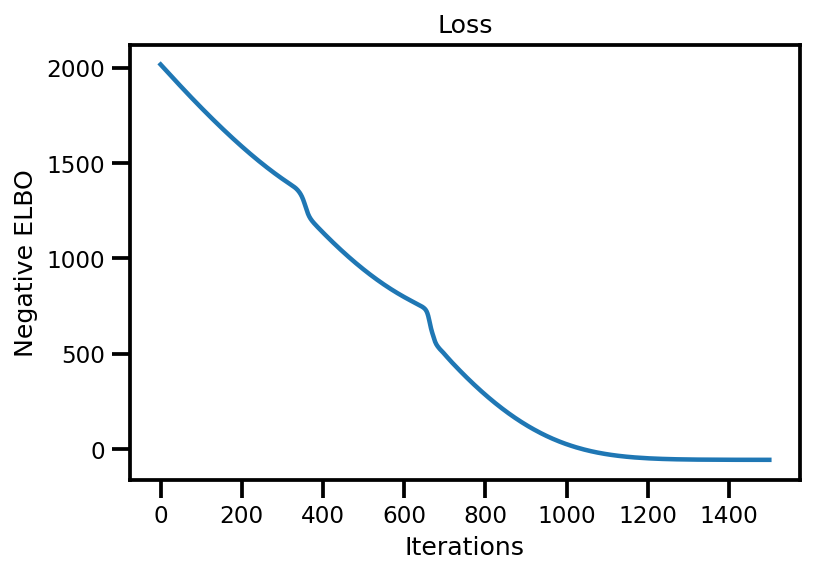

In [ ]:
fig, ax = plt.subplots()

ax.plot(svi_results.losses);
ax.set(
    title = "Loss",
    xlabel="Iterations",
    ylabel="Negative ELBO"
    );
plt.show()

In [ ]:
svi_results.params

{'kernel_length_auto_loc': DeviceArray(0.115, dtype=float32),
 'kernel_var_auto_loc': DeviceArray(1.291, dtype=float32),
 'sigma_auto_loc': DeviceArray(0.044, dtype=float32),
 'x_u': DeviceArray([[-0.23 ],
              [ 0.222],
              [-0.992],
              [ 0.773],
              [ 0.335],
              [ 0.447],
              [-0.936],
              [-0.004],
              [-0.341],
              [-0.849],
              [-0.118],
              [ 0.876],
              [-0.754],
              [-0.449],
              [ 0.559],
              [ 0.667],
              [ 0.968],
              [-0.553],
              [ 0.109],
              [-0.654]], dtype=float32)}

In [ ]:
from numpyro.infer import Predictive
predictive = Predictive(
    model=sgp_model,
    guide=delta_guide,
    params=svi_results.params,
    num_samples=1,
    return_sites=(
        "W",
        "Luu",
        "G",
        "y",
        "X",
        "x_u",

    ),
)

cond_params = predictive(key, x, y.T)
list(cond_params)

['G', 'Luu', 'W', 'X', 'x_u', 'y']

In [ ]:
for ikey, iparam in cond_params.items():

    print(f"{ikey}: {iparam.shape}")

G: (1, 1000)
Luu: (1, 20, 20)
W: (1, 20, 1000)
X: (1, 1000, 1)
x_u: (1, 20, 1)
y: (1, 1, 1000)


#### Predictions

In [ ]:
from chex import Array
from copy import deepcopy

def sparse_cholesky_factorization(
    learned_params: dict,
    x: Array, y: Array, 
    jitter: 1e-5
    ) -> dict:

    params = deepcopy(learned_params)
    n_samples = x.shape[0]
    m_samples = learned_params["x_u"].shape[0]
    jitter = 1e-5

    # calculate the cholesky factorization
    Kuu = rbf_kernel(
        params["x_u"], 
        params["x_u"], 
        params["kernel_var"], 
        params["kernel_length"]
        )
    Kuu += np.eye(m_samples) * jitter
    Luu = jnp.linalg.cholesky(Kuu)

    Kuf = rbf_kernel(
        params["x_u"], x,
        params["kernel_var"], 
        params["kernel_length"]
        )

    W = jax.scipy.linalg.solve_triangular(Luu, Kuf, lower=True)
    D = np.ones(n_samples) * params["sigma"]

    W_Dinv = W / D
    K = W_Dinv @ W.T
    K = jax.ops.index_add(K, Ninducing, 1.0)

    L = jnp.linalg.cholesky(K)

    # mean function
    y_residual = y # mean function
    y_2D = y_residual.reshape(-1, n_samples).T
    W_Dinv_y = W_Dinv @ y_2D

    params["Luu"] = Luu
    params["W_Dinv_y"] = W_Dinv_y
    params["L"] = L
    params["y_shape"] = y.shape[:-1]

    return params



In [ ]:
from chex import Array
from copy import deepcopy

def sparse_cholesky_factorization(
    cond_params: dict,
    jitter: 1e-5
    ) -> dict:

    # params = deepcopy(cond_params)
    n_samples = cond_params["X"].shape[0]
    m_samples = cond_params["x_u"].shape[0]


    W_Dinv = cond_params["W"] / cond_params["G"]
    K = W_Dinv @ cond_params["W"].T
    K = jax.ops.index_add(K, Ninducing, 1.0)

    L = jnp.linalg.cholesky(K)

    # mean function
    y_residual = cond_params["y"] # mean function
    y_2D = y_residual.reshape(-1, n_samples).T
    W_Dinv_y = W_Dinv @ y_2D

    cond_params["W_Dinv_y"] = W_Dinv_y
    cond_params["L"] = L

    return cond_params

In [ ]:
def demo_f(params, jitter):

    return params

In [ ]:
p_ = jax.vmap(demo_f, in_axes=(0, None))(cond_params, 1e-5)



In [ ]:
pred_params = jax.vmap(sparse_cholesky_factorization, in_axes=(0, None))(cond_params, 1e-5)

In [ ]:
def _pred_factorize(cond_params, params, xtest):

    Kux = rbf_kernel(
        cond_params["x_u"],
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    )
    Ws = jax.scipy.linalg.solve_triangular(
        cond_params["Luu"], Kux, lower=True
    )
    # pack
    pack = jnp.concatenate(
        [cond_params["W_Dinv_y"], Ws],
        axis=1
    )
    Linv_pack = jax.scipy.linalg.solve_triangular(
        cond_params["L"], pack, lower=True
    )
    # unpack
    Linv_W_Dinv_y = Linv_pack[:, :cond_params["W_Dinv_y"].shape[1]]
    Linv_Ws = Linv_pack[:, cond_params["W_Dinv_y"].shape[1]:]

    return Ws, Linv_W_Dinv_y, Linv_Ws


def sparse_predict_mean(cond_params: dict, params: dict, xtest: Array)-> Array:
    n_test_samples = xtest.shape[0]
    _, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(cond_params, params, xtest)
    loc_shape = cond_params["y"].shape[:-1] + (n_test_samples,)
    loc = (Linv_W_Dinv_y.T @ Linv_Ws).reshape(loc_shape)

    return loc.squeeze()


In [ ]:
cond_params["y"][0].shape

(1, 1000)

In [ ]:
def concat_dictionaries(a: dict, b: dict) -> dict:
    """
    Append one dictionary below another. If duplicate keys exist, then the key-value pair of the second supplied
    dictionary will be used.
    """
    return {**a, **b}

In [ ]:



mu = jax.vmap(sparse_predict_mean, in_axes=(0, None, None))(pred_params, learned_params, xtest)

In [ ]:
mu.shape

(1, 1000)

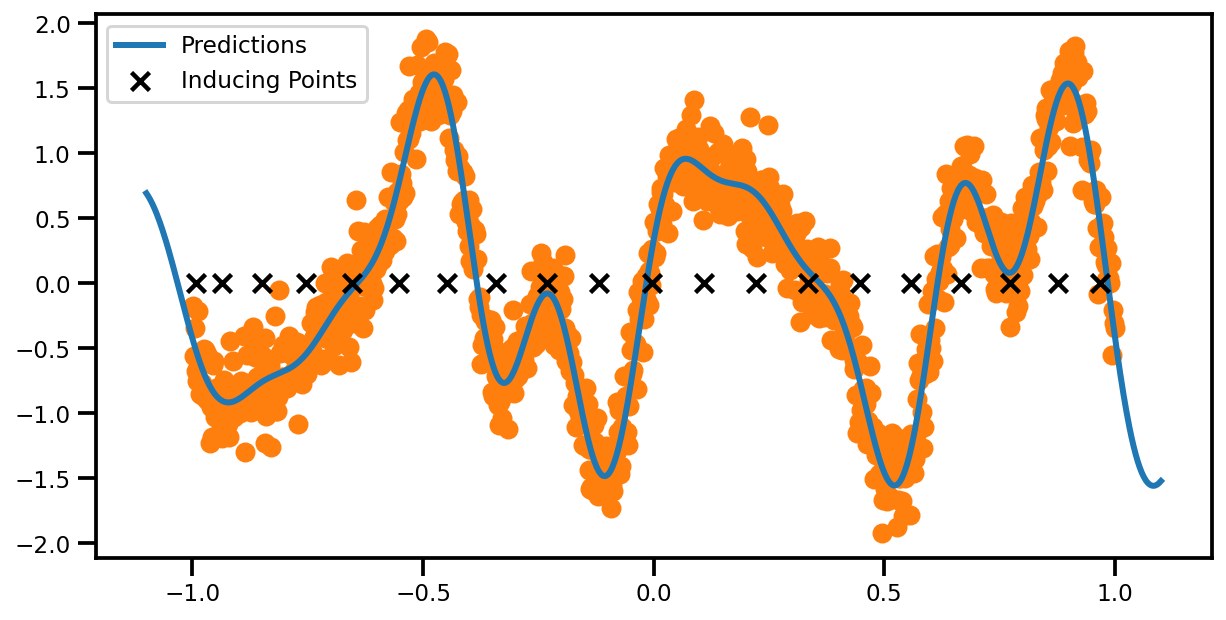

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu.ravel(), color="tab:blue", linewidth=3, label="Predictions")
# ax.fill_between(
#     xtest.ravel(),
#     mu.ravel() - one_stddev,
#     mu.ravel() + one_stddev,
#     alpha=0.4,
#     color="tab:blue",
# )
plt.scatter(cond_params["x_u"], np.zeros(Ninducing), 
            label="Inducing Points", color="black", marker="x",
            zorder=3
            )
# ax.plot(xtest, mu.ravel() - one_stddev_, linestyle="--", color="tab:blue")
# ax.plot(xtest, mu.ravel() + one_stddev_, linestyle="--", color="tab:blue")
plt.legend()
plt.show()

In [ ]:
def sparse_predict_covariance(params: dict, xtest: Array, noiseless: bool=False)-> Array:

    n_test_samples = xtest.shape[0]

    Ws, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)

    Kxx = rbf_kernel(
        xtest,
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    )

    if not noiseless:
        Kxx += jnp.eye(n_test_samples) * params["sigma"] #jax.ops.index_add(Kxx, n_test_samples, params["sigma"])

    Qss = Ws.T @ Ws

    cov = Kxx - Qss + Linv_Ws.T @ Linv_Ws

    cov_shape = params["y_shape"] + (n_test_samples, n_test_samples)
    cov = np.reshape(cov, cov_shape)

    return cov

def sparse_predict_variance(params: dict, xtest: Array, noiseless: bool=False)-> Array:

    n_test_samples = xtest.shape[0]
    Ws, Linv_W_Dinv_y, Linv_Ws = _pred_factorize(params, xtest)
    # TODO: have the kernel function have this property
    Kxxdiag = jnp.diag(
        rbf_kernel(
        xtest,
        xtest,
        params["kernel_var"],
        params["kernel_length"]
    ))
    if not noiseless:
        Kxxdiag += jnp.ones(n_test_samples) * params["sigma"] #jax.ops.index_add(Kxxdiag, n_test_samples, params["sigma"])

    Qssdiag = jnp.power(Ws, 2).sum(axis=0)

    var = Kxxdiag - Qssdiag + jnp.power(Linv_Ws, 2).sum(axis=0)

    var_shape = params["y_shape"] + (n_test_samples,)
    var = np.reshape(var, var_shape)

    return var

In [ ]:
mu = sparse_predict_mean(params, xtest)
cov = sparse_predict_covariance(params, xtest, noiseless=False)
var = sparse_predict_variance(params, xtest, noiseless=False)

one_stddev = 1.96 * jnp.sqrt(np.diag(cov.squeeze()))
one_stddev_ = 1.96 * jnp.sqrt(var.squeeze())
# chex.assert_tree_all_close(one_stddev, one_stddev_)

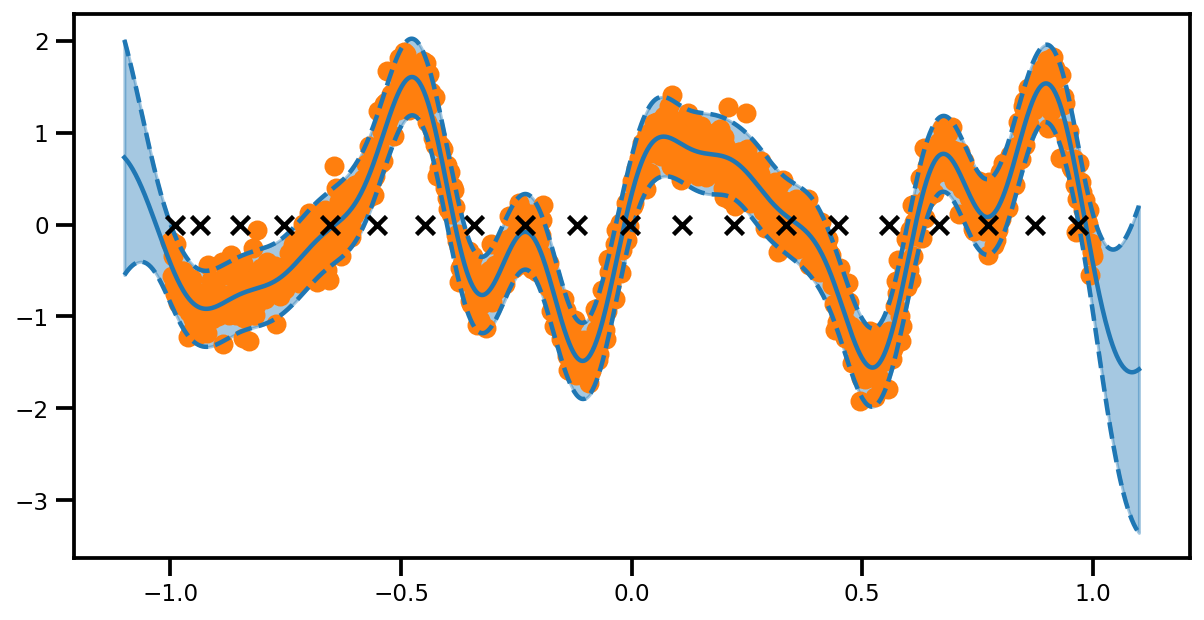

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, y.squeeze(), "o", color="tab:orange")
ax.plot(xtest, mu.ravel(), color="tab:blue")
ax.fill_between(
    xtest.ravel(),
    mu.ravel() - one_stddev,
    mu.ravel() + one_stddev,
    alpha=0.4,
    color="tab:blue",
)
plt.scatter(learned_params["x_u"], np.zeros(Ninducing), 
            label="Inducing Points", color="black", marker="x",
            zorder=3
            )
ax.plot(xtest, mu.ravel() - one_stddev_, linestyle="--", color="tab:blue")
ax.plot(xtest, mu.ravel() + one_stddev_, linestyle="--", color="tab:blue")
plt.show()